In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('repaired-tsv/1887-0024.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nom       85 non-null     object 
 1   année     76 non-null     float64
 2   notes     11 non-null     object 
 3   adresse   85 non-null     object 
 4   horaires  61 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.4+ KB


In [4]:
# count how many rows have nom field containing "Mme"
count_mme = df['nom'].str.contains('Mme', na=False).sum()
count_mlle = df['nom'].str.contains('Mlle', na=False).sum()

In [5]:
# iterate through all the tsvs under repaired-tsv/ and save the counts of Mme and Mlle for each file into a dataframe
import os
results = []
filenames = os.listdir('repaired-tsv/')
filenames.sort()
for filename in filenames:
    if filename.endswith('.tsv'):
        df = pd.read_csv(os.path.join('repaired-tsv/', filename), sep='\t')
        try:
            count_mme = df['nom'].str.contains('Mme', na=False).sum()
            count_mlle = df['nom'].str.contains('Mlle', na=False).sum()
            results.append({'filename': filename.replace('.tsv', ''), 'count_mme': count_mme, 'count_mlle': count_mlle})
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            exit(0)
results_df = pd.DataFrame(results)
results_df

,filename,count_mme,count_mlle
0,1887-0022,0,0
1,1887-0023,0,0
2,1887-0024,1,1
3,1887-0025,0,0
4,1887-0026,1,1
...,...,...,...
4161,1906-0540,0,0
4162,1906-0541,0,0
4163,1906-0542,0,1
4164,1906-0543,0,0


In [6]:
# analyse the results
results_df['total'] = results_df['count_mme'] + results_df['count_mlle']
results_df = results_df.sort_values(by='total', ascending=False)
results_df

,filename,count_mme,count_mlle,total
3170,1903-0129,8,6,14
2964,1902-0139,8,6,14
3790,1905-0159,7,6,13
4018,1906-0169,5,8,13
3485,1904-0152,7,5,12
...,...,...,...,...
1407,1894-0325,0,0,0
1408,1894-0326,0,0,0
1409,1894-0327,0,0,0
1410,1894-0328,0,0,0


In [7]:
sum(results_df['total'])

1203

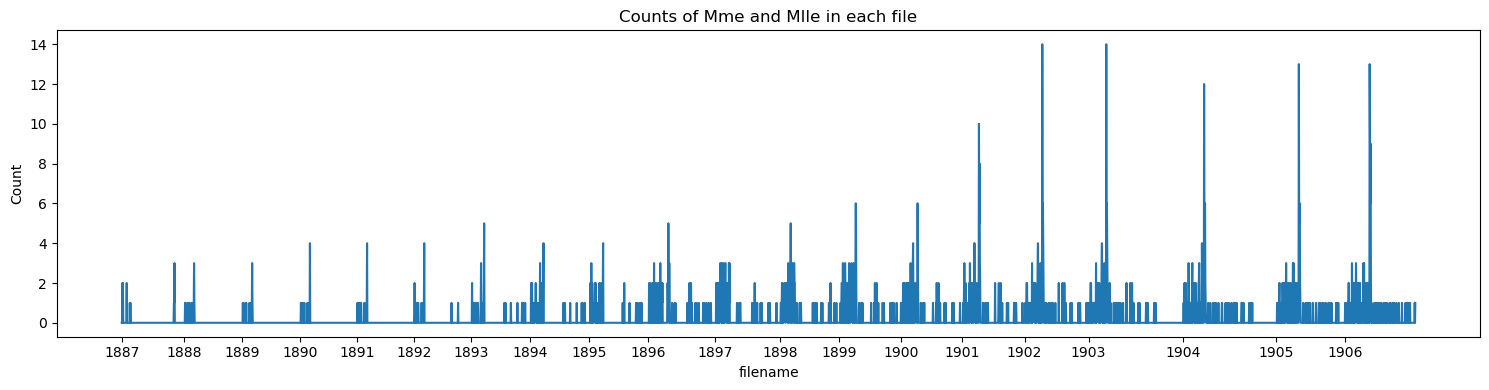

In [8]:
import matplotlib.pyplot as plt

# sort by filename (works for "YYYY-NNNN" style)
results_df = results_df.sort_values('filename').copy()

# keep all rows (your filter is currently redundant)
non_zero_df = results_df[results_df['total'] >= 0].copy()

# extract year from "1903-0129" -> 1903
non_zero_df['year'] = non_zero_df['filename'].str.split('-', n=1).str[0].astype(int)

# plot
ax = non_zero_df.set_index('filename')['total'].plot(
    kind='line', stacked=False, figsize=(15, 4)
)

# set x-axis ticks: first occurrence of each year
first_idx_per_year = non_zero_df.groupby('year').head(1).index.tolist()
year_labels = non_zero_df.loc[first_idx_per_year, 'year'].astype(str).tolist()

ax.set_xticks(first_idx_per_year)
ax.set_xticklabels(year_labels, rotation=0)

plt.ylabel('Count')
plt.title('Counts of Mme and Mlle in each file')
plt.tight_layout()
plt.savefig('mme_mlle_counts_per_file_line_plot.pdf')
plt.show()

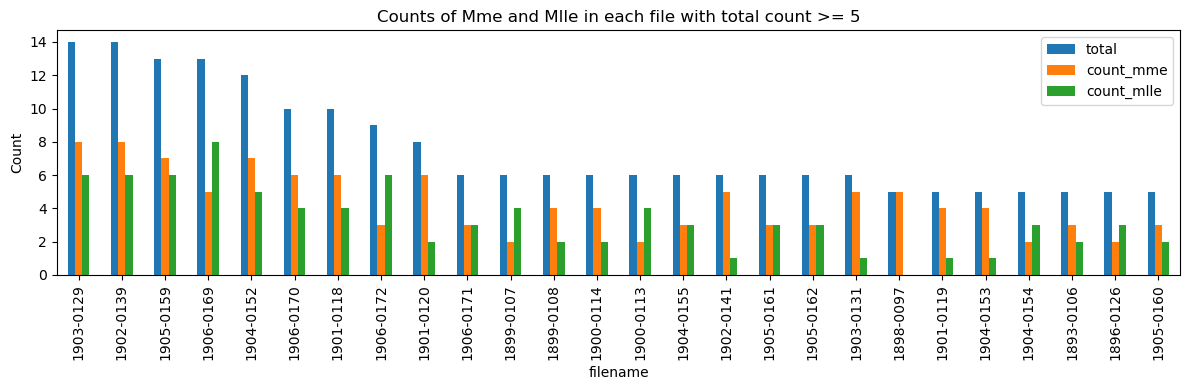

In [9]:
# bar plot the count_mme, count_mlle and total for each file
import matplotlib.pyplot as plt
results_df.sort_values(by='total', ascending=False, inplace=True)
non_zero_df = results_df[results_df['total'] >= 5]
non_zero_df.set_index('filename')[['total', 'count_mme', 'count_mlle']].plot(kind='bar', stacked=False, figsize=(12, 4))
plt.ylabel('Count')
plt.title('Counts of Mme and Mlle in each file with total count >= 5')
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('mme_mlle_counts_per_file_bar_plot.pdf')
plt.show()

In [10]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4166 entries, 3170 to 2083
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    4166 non-null   object
 1   count_mme   4166 non-null   int64 
 2   count_mlle  4166 non-null   int64 
 3   total       4166 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 162.7+ KB


In [11]:
len(results_df[results_df['total'] == 0]), len(results_df[results_df['total'] == 1]), len(results_df[results_df['total'] == 2]), len(results_df[results_df['total'] == 3])

(3420, 510, 150, 45)

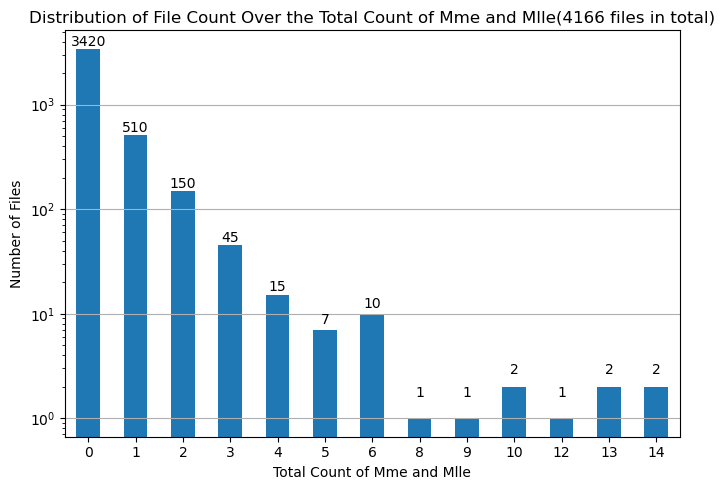

In [16]:
# draw bar plot of the distribution of total counts
total_counts = results_df['total'].value_counts().sort_index()
total_counts.plot(kind='bar', figsize=(7, 5))

plt.xlabel('Total Count of Mme and Mlle')
plt.ylabel('Number of Files')
plt.title('Distribution of File Count Over the Total Count of Mme and Mlle(4166 files in total)')
plt.xticks(rotation=0)
# log scale
plt.yscale('log')
# add text of values
for i, v in enumerate(total_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
# add grid
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('mme_mlle_total_count_distribution.pdf')
plt.show()

# Poisson Distribution?

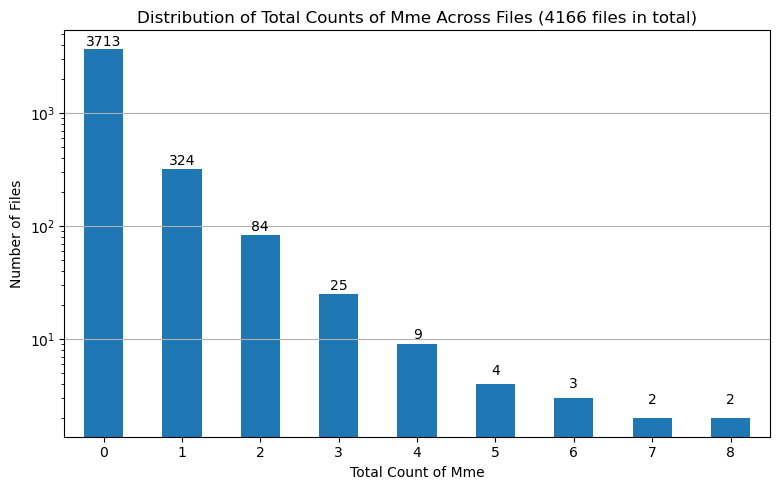

In [24]:
# draw bar plot of the distribution of total counts
total_counts = results_df['count_mme'].value_counts().sort_index()
total_counts.plot(kind='bar', figsize=(8, 5))
plt.xlabel('Total Count of Mme')
plt.ylabel('Number of Files')
plt.title('Distribution of Total Counts of Mme Across Files (4166 files in total)')
plt.xticks(rotation=0)
plt.tight_layout()
# log scale
plt.yscale('log')
# add text of values
for i, v in enumerate(total_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
# add grid
plt.grid(axis='y')
plt.show()

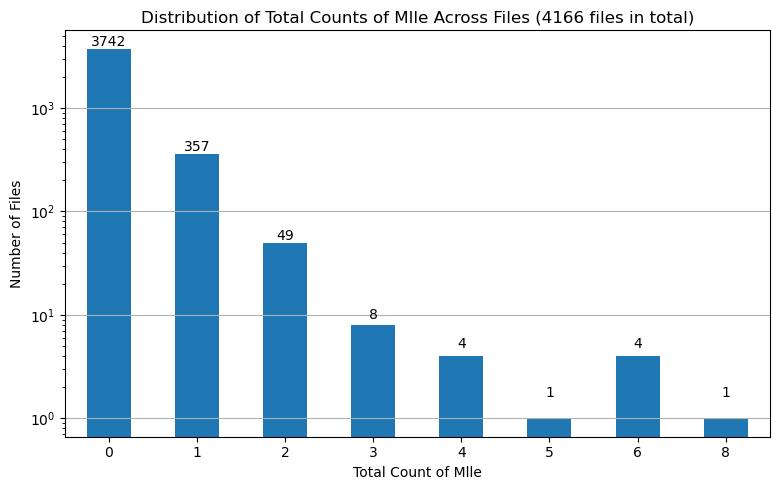

In [25]:
# draw bar plot of the distribution of total counts
total_counts = results_df['count_mlle'].value_counts().sort_index()
total_counts.plot(kind='bar', figsize=(8, 5))
plt.xlabel('Total Count of Mlle')
plt.ylabel('Number of Files')
plt.title('Distribution of Total Counts of Mlle Across Files (4166 files in total)')
plt.xticks(rotation=0)
plt.tight_layout()
# log scale
plt.yscale('log')
# add text of values
for i, v in enumerate(total_counts):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
# add grid
plt.grid(axis='y')
plt.show()

In [58]:
# iterate through all the tsvs under repaired-tsv/
# Add one column called sexe
# for each row with Mme or Mlle in the nom field
# set the sexe to Mme or Mlle accordingly
# save the new tsvs in the folder analysed-tsv/
import os
input_folder = 'repaired-tsv/'
output_folder = 'analysed-tsv/'
os.makedirs(output_folder, exist_ok=True)
filenames = os.listdir(input_folder)
filenames.sort()
for filename in filenames:
    if filename.endswith('.tsv'):
        df = pd.read_csv(os.path.join(input_folder, filename), sep='\t')
        def determine_sexe(nom):
            if pd.isna(nom):
                return ''
            elif 'Mme' in nom:
                return 'Mme'
            elif 'Mlle' in nom:
                return 'Mlle'
            else:
                return ''
        df['sexe'] = df['nom'].apply(determine_sexe)
        # the column année is always float, convert it to int if possible, be careful if it's not able to convert to int, to str
        def convert_annee(annee):
            if pd.isna(annee):
                return ''
            try:
                annee_int = int(annee)
                return str(annee_int)
            except:
                return str(annee)
        df['année'] = df['année'].apply(convert_annee)
        df.to_csv(os.path.join(output_folder, filename), sep='\t', index=False)

In [59]:
results_df.to_csv('mme_mlle_counts.tsv', sep='\t', index=False)

In [ ]:
# count all the Mme and Mlle in the analysed-tsv/, put all these Mme and Mlle rows together
total_mme = 0
total_mlle = 0
filenames = os.listdir(output_folder)
filenames.sort()

all_mme_mlle_rows = []
for filename in filenames:
    if filename.endswith('.tsv'):
        df = pd.read_csv(os.path.join(output_folder, filename), sep='\t')
        total_mme += (df['sexe'] == 'Mme').sum()
        total_mlle += (df['sexe'] == 'Mlle').sum()
        year, page = filename.replace('.tsv', '').split('-')
        mme_mlle_rows = df[df['sexe'].isin(['Mme', 'Mlle'])].copy()
        mme_mlle_rows['year'] = year
        mme_mlle_rows['page'] = page
        all_mme_mlle_rows.append(mme_mlle_rows)
all_mme_mlle_df = pd.concat(all_mme_mlle_rows, ignore_index=True)
all_mme_mlle_df['année'] = all_mme_mlle_df['année'].apply(convert_annee)
all_mme_mlle_df.to_csv('all_mme_mlle.tsv', sep='\t', index=False)
print(f"Total Mme: {total_mme}, Total Mlle: {total_mlle}, Total: {total_mme + total_mlle}")

Total Mme: 671, Total Mlle: 532, Total: 1203


In [62]:
def extract_year_page(year, page):
    return all_mme_mlle_df[(all_mme_mlle_df['year'] == year) & (all_mme_mlle_df['page'] == page)]

In [63]:
extract_year_page('1906', '0169')

,nom,année,notes,adresse,horaires,sexe,year,page
1136,Danel (Mlle),1876,NaN,av. d'Orléans 110,Mar. Ven. 1 à 3,Mlle,1906,0169
1137,Acher (Mme),1895,NaN,Monge 73,NaN,Mme,1906,0169
1138,Alsot-Oguse (Mlle),1903,NaN,"boul. Edgar-Quinet, 33",NaN,Mlle,1906,0169
1139,Audy (Mlle),1894,NaN,Hauteville 48,NaN,Mlle,1906,0169
1140,Bassot (Mlle),1901,NaN,"boul. St-Martin, 6",NaN,Mlle,1906,0169
1141,Baudet (M. et Mme),1901,NaN,Richelieu 28 bis,NaN,Mme,1906,0169
1142,Bernard (Mme),1896,NaN,Arcole 21,NaN,Mme,1906,0169
1143,Malesky (Mlle),1885,NaN,"Poulletier, 5",1 à 3,Mlle,1906,0169
1144,Peskinè-Hausman (Mlle),,NaN,"Sq. Croisic 5, boul. Montparnasse 12",L. M. V. 2 à 4,Mlle,1906,0169
1145,Bertrand (M. et Mme),,NaN,Miromesnil 29,NaN,Mme,1906,0169


In [64]:
extract_year_page('1905', '0159')

,nom,année,notes,adresse,horaires,sexe,year,page
1021,Danel (Mlle),1876,O I,"av. d'Orléans 110,",Mar. Ven. 1 à 3.,Mlle,1905,0159
1022,Acher (Mme),1895,NaN,Monge 73.,NaN,Mme,1905,0159
1023,Audy (Mlle),1894,NaN,Hauteville 48.,NaN,Mlle,1905,0159
1024,Baudet (M. et Mme),1901,NaN,Richelieu 28 bis.,NaN,Mme,1905,0159
1025,Bernard (Mme),1896,NaN,Arcole 17.,NaN,Mme,1905,0159
1026,Bertrand (M. et Mme),,NaN,Miromesnil 29.,NaN,Mme,1905,0159
1027,Bidel (Mme),1901,NaN,boul. Reuilly 16.,NaN,Mme,1905,0159
1028,Malesky (Mlle),1885,NaN,"Poulletier, 5,",1 à 3,Mlle,1905,0159
1029,Peskine-Hausman (Mlle),,NaN,"Sq. Croisic 5, boul. Montparnasse 12,",L. M. V. 2 à 4.,Mlle,1905,0159
1030,Bouret (Mlle),1896,NaN,Fidélité 11.,NaN,Mlle,1905,0159


In [65]:
extract_year_page('1904', '0152')

,nom,année,notes,adresse,horaires,sexe,year,page
910,Danel (Mlle) O ✶,1876,NaN,av. d'Orléans 110,Mar. Ven. 1 à 3,Mlle,1904,0152
911,Durand (Mme),1898,NaN,"Bd Vaugirard, 4",NaN,Mme,1904,0152
912,Acher (Mme),1895,NaN,Monge 73,NaN,Mme,1904,0152
913,Audy (Mlle),1894,NaN,Hauteville 48,NaN,Mlle,1904,0152
914,Bernard (Mme),1896,NaN,Arcole 17,NaN,Mme,1904,0152
915,Bertrand (M. et Mme),,NaN,Miromesnil 29,NaN,Mme,1904,0152
916,Bidel (Mme),1901,NaN,boul. Reuilly 16,NaN,Mme,1904,0152
917,Malesky (Mlle),1885,NaN,"Poulletier, 5",1 à 3,Mlle,1904,0152
918,Bouret (Mlle),1896,NaN,Fidélité 11,NaN,Mlle,1904,0152
919,Burau (Mlle),1895,NaN,a. Wagram 32,NaN,Mlle,1904,0152


In [66]:
extract_year_page('1903', '0129')

,nom,année,notes,adresse,horaires,sexe,year,page
795,Danel(Mlle),1876,I,av. d'Orléans 110,Mar. Ven. 1 à 3.,Mlle,1903,0129
796,Durand (Mme),1898,NaN,"Bd Vaugirard, 4.",NaN,Mme,1903,0129
797,Acher (Mme),1895,NaN,Monge 73.,NaN,Mme,1903,0129
798,Audy (Mlle),1894,NaN,Hauteville 48.,NaN,Mlle,1903,0129
799,Baudet (M. et Mme),1901,NaN,Richelieu 28 bis.,NaN,Mme,1903,0129
800,Baume (Mlle),1900,NaN,Douai 25.,NaN,Mlle,1903,0129
801,Bernard (Mme),1896,NaN,Arcole 17.,NaN,Mme,1903,0129
802,Bertrand (M. et Mme),,NaN,Miromesnil 29.,NaN,Mme,1903,0129
803,Bidel (Mme),1901,NaN,boul. Reuilly 16.,NaN,Mme,1903,0129
804,Malesky (Mlle),1885,NaN,"Poulletier, 5",1 à 3,Mlle,1903,0129


In [83]:
extract_year_page('1902', '0139').drop(columns=['year', 'page'])

,nom,année,notes,adresse,horaires,sexe
694,Danel (Mlle),1876,✶ I,av. d'Orléans 110,Mar. Ven. 1 à 3,Mlle
695,Durand (Mme),1898,NaN,"Bd Vaugirard, 4",NaN,Mme
696,Acher (Mme),1895,NaN,Monge 73,NaN,Mme
697,Audy (Mlle),1894,NaN,Hauteville 43,NaN,Mlle
698,Baudet (M. et Mme),1901,NaN,Richelieu 28 bis,NaN,Mme
699,Baume (Mlle),1900,NaN,Douai 25,NaN,Mlle
700,Bernard (Mme),1896,NaN,Arcole 17,NaN,Mme
701,Bertrand (M. et Mme),,NaN,Miromesnil 29,NaN,Mme
702,Bidel (Mme),1901,NaN,boul. Reuilly 16,NaN,Mme
703,Malesky (Mlle),1885,NaN,"Poulletier, 5",1 à 3,Mlle


In [78]:
# make the list of nom of above 5 pages into 5 sets
set_1906_0169 = set(extract_year_page('1906', '0169')['nom'].dropna().unique())
set_1905_0159 = set(extract_year_page('1905', '0159')['nom'].dropna().unique())
set_1904_0152 = set(extract_year_page('1904', '0152')['nom'].dropna().unique())
set_1903_0129 = set(extract_year_page('1903', '0129')['nom'].dropna().unique())
set_1902_0139 = set(extract_year_page('1902', '0139')['nom'].dropna().unique())

In [85]:
# count the appearance of each item 1902_0139 in other sets
for nom in extract_year_page('1902', '0139')['nom']:
    count = 1
    if nom in set_1903_0129:
        count += 1
    if nom in set_1904_0152:
        count += 1
    if nom in set_1905_0159:
        count += 1
    if nom in set_1906_0169:
        count += 1
    print(f"{nom}: {count}")

Danel (Mlle): 3
Durand (Mme): 3
Acher (Mme): 5
Audy (Mlle): 5
Baudet (M. et Mme): 4
Baume (Mlle): 2
Bernard (Mme): 5
Bertrand (M. et Mme): 5
Bidel (Mme): 5
Malesky (Mlle): 5
Bouret (Mlle): 5
Burau (Mlle): 5
Chaillot (Mme): 4
Chauvin (M. et Mme): 4
